### Evaluator Optimizer

- Topic Input
- LLM1 - generate a joke
- LLM2 - evaluate the joke 
    - May be send it back to LLM1 to regenerate the joke with feedback, if evaluation failed
- If evaluation passed, output provided


In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import operator

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
model_generator = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

model_evaluator = init_chat_model(
    model="gemini-2.5-flash-lite",
    model_provider="google_genai",
    temperature=0.7,
)

In [3]:
# Create State
class JokeState(TypedDict):
    topic: str
    joke: str
    feedback: str
    funny_or_not: str

In [6]:
# Sturctured output for Evaluator
class FeedbackSchema(BaseModel):
    feedback: str = Field(description="Feedback for the joke to be improved, if it is not funny")
    grade: Literal["funny", "not funny"] = Field(description="Grade the joke, if it is funny or not funny")

# Augment model with structured output for evaluator
model_evaluator_structured = model_evaluator.with_structured_output(FeedbackSchema)

In [16]:
def generator_node(state: JokeState) -> JokeState:
    """LLM Generator"""
    if state.get("feedback"):
        prompt = f"Write a joke about {state['topic']}, based on the feedback: {state['feedback']}"
        joke = model_generator.invoke(prompt).content
    else:
        prompt = f"Write a joke about {state['topic']}"
        joke = model_generator.invoke(prompt).content
    return {"joke": joke}

def evaluator_node(state: JokeState) -> JokeState:
    """LLM Evaluator"""
    messages = [
        SystemMessage(content="You are a funny joke evaluator. Evaluate the joke and group it into funny or not funny, if it is not funny, provide feedback to improve the joke"),
        HumanMessage(content="Evaluate this joke: " + state["joke"]),
    ]

    feedback = model_evaluator_structured.invoke(messages)
    return {"feedback": feedback.feedback, "funny_or_not": feedback.grade}


In [17]:
def route_joke(state: JokeState) -> Literal["Rejected + Feedback", "Accepted"]:
    """Route the joke based on the evaluator's feedback"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    else:
        return "Rejected + Feedback"

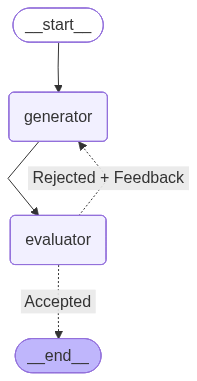

In [18]:
# Create Graph

graph = StateGraph(JokeState)

# add nodes
graph.add_node("evaluator", evaluator_node)
graph.add_node("generator", generator_node)

# add edges
graph.add_edge(START, "generator")
graph.add_edge("generator", "evaluator")
graph.add_conditional_edges("evaluator", route_joke, {"Accepted": END, "Rejected + Feedback": "generator"})

# compile the graph
workflow = graph.compile()
workflow

In [21]:
# Run the workflow
from IPython.display import Markdown
initial_state = {"topic": "Time Travel"}
final_state = workflow.invoke(initial_state)
Markdown(final_state["topic"] + "\n\n" + final_state["joke"])

Time Travel

Why did the cat join a time-traveling band? 

Because it wanted to purr-form in every era before it was cat-astrophically erased from existence in the next temporal audit.